# Functions

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from io import StringIO
from scipy.optimize import minimize
from tqdm import tqdm
from joblib import Parallel, delayed

def equally_weighted(returns, rolling = False, window=60):
    """
    returns equally weighted portfolio weights
    if rolling = True, returns rolling equally weighted portfolio weights with window size rolling_window
    """
    n = returns.shape[1]
    
    if rolling:
        n_periods = returns.shape[0] - window +1
        weights = pd.DataFrame(
            np.tile(1/n, (n_periods, n)),
            index=returns.index[window-1:],
            columns=returns.columns
        )
        return weights
        
    else: 
        return np.repeat(1/n, n)

#=======================================================================================================

def MVP_no_constraints(returns, rf):
    """
    returns the mean variance portfolio weights without any constraints on weights
    weights are calculated based on the entire sample returns DataFrame.
    """
    # Handle different rf types
    if isinstance(rf, pd.DataFrame):
        # If DataFrame, extract first column as Series
        rf_values = rf.iloc[:, 0]
    elif isinstance(rf, pd.Series):
        # If Series, use as is
        rf_values = rf
    else:
        # If scalar (int/float), use directly
        rf_values = rf
    
    # Calculate excess returns
    if isinstance(rf_values, pd.Series):
        # Use .sub() for Series to handle broadcasting and index alignment
        excess_returns = returns.sub(rf_values, axis=0)
    else:
        # For scalar, simple subtraction works
        excess_returns = returns - rf_values

    mu = excess_returns.mean().values
    sigma = returns.cov().values

    numerator = np.linalg.inv(sigma) @ mu
    denominator = np.ones(mu.shape[0]) @ numerator
    return (numerator / denominator)

#=======================================================================================================

def objective_MVP(weights, mu, cov):
    portfolio_return = weights.T @ mu
    portfolio_variance = weights.T @ cov @ weights
    sharpe = portfolio_return/np.sqrt(portfolio_variance)
    return -sharpe

def MVP_long_only(returns):
    mu = returns.mean()
    V = returns.cov()
    # Define the constraint that the weights sum to 1
    constraints = ({'type': 'eq', 
                    'fun': lambda weights: np.sum(weights)- 1})
    # Define the bounds for each weight (0 <= weight <= 1)
    bounds = ((0,1),) * (len(V))
    # Define the initial guess for weights
    initial_weights = np.repeat(1/len(V), len(V))
    # Use scipy.optimize.minimize to find the optimal weights
    result = minimize(objective_MVP, initial_weights, args = (mu,V,),
                      method = 'SLSQP',bounds = bounds, constraints = constraints)
    # Extract the optimal weights
    optimal_weights = result.x
    return optimal_weights

#=======================================================================================================

def MVP_rolling_window_weights(returns, window, weights_function, n_jobs=-1, **kwargs):
    """
    returns the mean variance portfolio weights for a rolling window
    Parallelized for speed
    """
    n_periods = len(returns)
    
    def compute_weights(i):
        sample = returns.iloc[i - window : i]
        return weights_function(sample, **kwargs)
    
    # Parallel processing with progress bar
    mvp_weights = Parallel(n_jobs=n_jobs)(
        delayed(compute_weights)(i) 
        for i in tqdm(range(window, n_periods))
    )
    
    return pd.DataFrame(mvp_weights, 
                       columns=returns.columns, 
                       index=returns.index[window:])

#=======================================================================================================

def GMV_no_constraints(returns):
    """
    returns the GMV portfolio weights without any constraints on weights
    weights are calculated based on the entire sample returns DataFrame.
    """
    sigma = returns.cov().values

    numerator = np.linalg.solve(sigma, np.ones(sigma.shape[0]))
    return (numerator / numerator.sum())

#=======================================================================================================

def objective_GMV(weights, V):
    portfolio_variance = weights.T @ V @ weights
    return portfolio_variance

def GMV_long_only(returns):
    V = returns.cov()
    # Define the constraint that the weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)- 1})
    # Define the bounds for each weight (0 <= weight <= 1)
    bounds = ((0,1),) * (len(V))
    # Define the initial guess for the weights
    initial_weights = np.repeat(1/len(V), len(V))
    # Use scipy.optimize.minimize to find the optimal weights
    result = minimize(objective_GMV, initial_weights, args=(V,), 
                      method='SLSQP',bounds=bounds, constraints=constraints)
    # Extract the optimal weights
    optimal_weights = result.x
    return optimal_weights

#=======================================================================================================

def GMV_rolling_window_weights(returns, window, weights_function, n_jobs=-1, **kwargs):
    """
    returns rolling GMV portfolio weights without any constraints on weights
    Parallelized for speed
    """
    n_periods = len(returns)
    
    def compute_weights(i):
        sample = returns.iloc[i - window : i]
        return weights_function(sample, **kwargs)
    
    # Parallel processing with progress bar
    gmv_weights = Parallel(n_jobs=n_jobs)(
        delayed(compute_weights)(i) 
        for i in tqdm(range(window, n_periods))
    )
    
    return pd.DataFrame(gmv_weights, 
                       columns=returns.columns, 
                       index=returns.index[window:])

#=======================================================================================================

def out_of_sample_portfolio_returns(returns, weights_function, **kwargs):
    """
    computes out-of-sample portfolio returns given a returns DataFrame and a weights function
    weights_function should be a function that takes returns and **kwargs as input and returns weights DataFrame
    weights function should be designed to compute rolling weights to account for rebalancing
    """
    weights = weights_function(returns, **kwargs).dropna()
    sample_rets = returns[weights.index[0]:]

    #calculate out of sample portfolio returns as: weights(t-1) * returns(t)
    portfolio_rets = (weights.shift() * sample_rets).sum(axis=1)  
    
    #skip first row as they do not have any prior weights, so cannot be used for out-of-sample returns
    return portfolio_rets.iloc[1:] 

#=======================================================================================================

def sharpe_ratio(returns, risk_free_rate, periods_per_year=12):
    """
    computes the annualized Sharpe ratio of a returns series
    risk free rate is in decimal form (e.g., 0.03 for 3%)
    perods_per_year: number of return periods in a year (e.g., 12 for monthly returns, quarterly=4, daily=252)
    """

    if isinstance (returns, pd.DataFrame):
        return returns.aggregate(sharpe_ratio, risk_free_rate=risk_free_rate, periods_per_year=periods_per_year)

    
    elif isinstance (returns, pd.Series):
        ann_return = returns.mean() * periods_per_year
        ann_volatility = returns.std() * np.sqrt(periods_per_year)
        return (ann_return - risk_free_rate) / ann_volatility

# Data Import

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from io import StringIO

start_date = "2000-01-01"
end_date   = "2025-10-31"

## Import required prices data for S&P 500 companies
# Download page with browser-like headers (to avoid 403)
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers).text

# Read all tables from the HTML
sp500_tables = pd.read_html(StringIO(html))

# Finding the table that contains the 'Symbol' column
sp500_table = None
for i, tbl in enumerate(sp500_tables):
    print(f"Table {i} columns:", list(tbl.columns))
    if "Symbol" in tbl.columns:
        sp500_table = tbl
        break

# Extract ticker list
sp500_tickers = sp500_table["Symbol"].unique().tolist()

# Download daily prices (Close already adjusted because auto_adjust=True)
sp500_data = yf.download(
    sp500_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True
)

# Take only the 'Close' level and resample to monthly data (adjusted close prices)
sp500_prices = sp500_data["Close"].resample('M').last()

# Drop rows where all remaining tickers are NaN
sp500_prices = sp500_prices.dropna(how="all")

# Drop tickers (columns) with missing monthly return(s)
df_sp500_prices = sp500_prices.dropna(axis=1, how='any')
df_rets = df_sp500_prices.pct_change().iloc[1:]

#=================================================================================

# download index prices
sp500_index_data = yf.download(
    ["^GSPC"],
    start=start_date,
    end=end_date,
    auto_adjust=True
)

# Take only the 'Close' level and resample to monthly data (adjusted close prices)
sp500_index_prices = sp500_index_data["Close"].resample('M').last()
sp500_index_rets = sp500_index_prices.pct_change().iloc[1:]
sp500_index_rets.rename(columns={"^GSPC": "SP500 Index"}, inplace=True)


Table 0 columns: [0, 1]
Table 1 columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-10-31)')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-10-31)')
C:\Users\g\AppData\Local\Temp\ipykernel_11332\3346895516.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_prices = sp500_data["Close"].resample('M').last()
C:\Users\g\AppData\Local\Temp\ipykernel_11332\3346895516.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_prices = sp500_data["Close"].resample('M').last()
[*********************100%

Execution

# Execution

In [ ]:
# portfolio_rets_mvp = out_of_sample_portfolio_returns(df_rets, MVP_rolling_weights, rolling_window=60, long_only=False).rename("MVP")
# portfolio_rets_gmv = out_of_sample_portfolio_returns(df_rets, MVP_rolling_weights, rolling_window=60, long_only=False, GMV=True).rename("GMV")
# portfolio_rets_mvp_c = out_of_sample_portfolio_returns(df_rets, MVP_rolling_weights, rolling_window=60, long_only=True).rename("MVP Long Only")
# portfolio_rets_gmv_c = out_of_sample_portfolio_returns(df_rets, MVP_rolling_weights, rolling_window=60, long_only=True, GMV=True).rename("GMV Long Only")

# df_portfolio = pd.concat([sp500_index_rets.loc[portfolio_rets_mvp.index[0]:portfolio_rets_mvp.index[-1]], portfolio_rets_mvp, portfolio_rets_gmv, portfolio_rets_mvp_c, portfolio_rets_gmv_c], axis=1)
# df_portfolio.to_csv("portfolio_returns.csv")
# sharpe_ratio(df_portfolio, risk_free_rate=0.0).round(4)


SP500 Index      0.6398
MVP              0.2314
GMV              0.0934
MVP Long Only    1.0110
GMV Long Only    0.7322
dtype: float64

### No weight constraint analysis

Min: -14.657815167437013
Max: 18.617762012799176
Mean: 0.002873563218390733
Std: 4.8643765534987855


<Axes: >

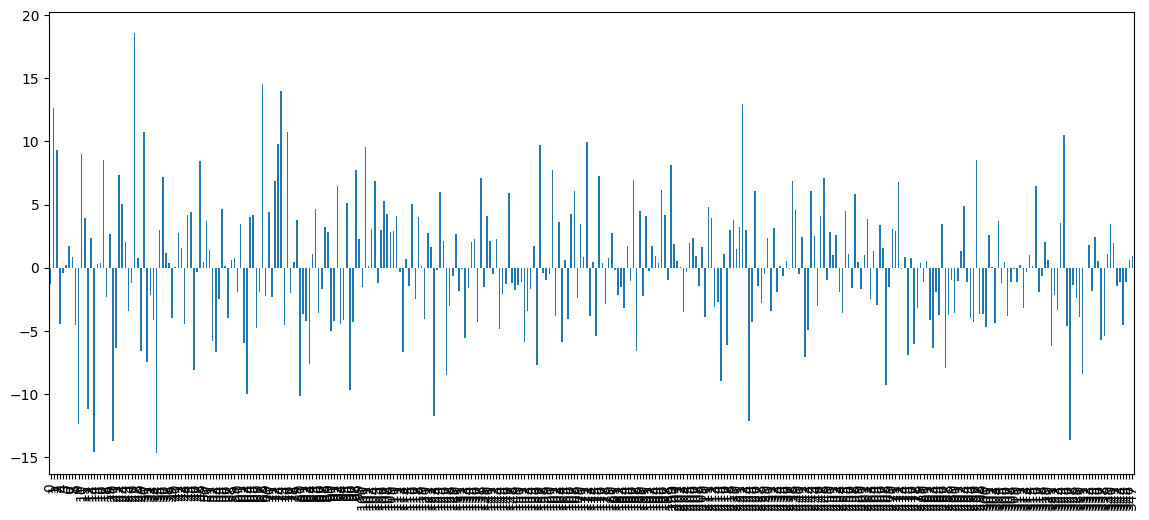

In [7]:
x = pd.Series(MVP_weights(df_rets.iloc[-60:], rf = 0.0))
print(f'Min: {x.min()}\nMax: {x.max()}\nMean: {x.mean()}\nStd: {x.std()}')
x.plot.bar(figsize=(14,6))

Min: -3.8094339458828776
Max: 2.4404762660447874
Mean: 0.0028735632183908098
Std: 0.7857903063185186


<Axes: >

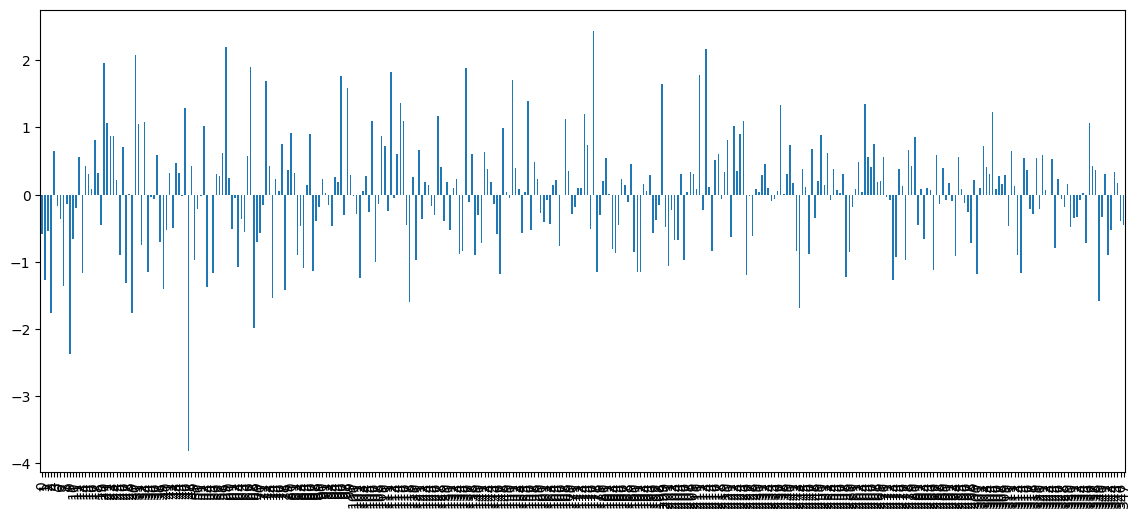

In [6]:
x = pd.Series(GMV_weights(df_rets.iloc[-60:]))
print(f'Min: {x.min()}\nMax: {x.max()}\nMean: {x.mean()}\nStd: {x.std()}')
x.plot.bar(figsize=(14,6))

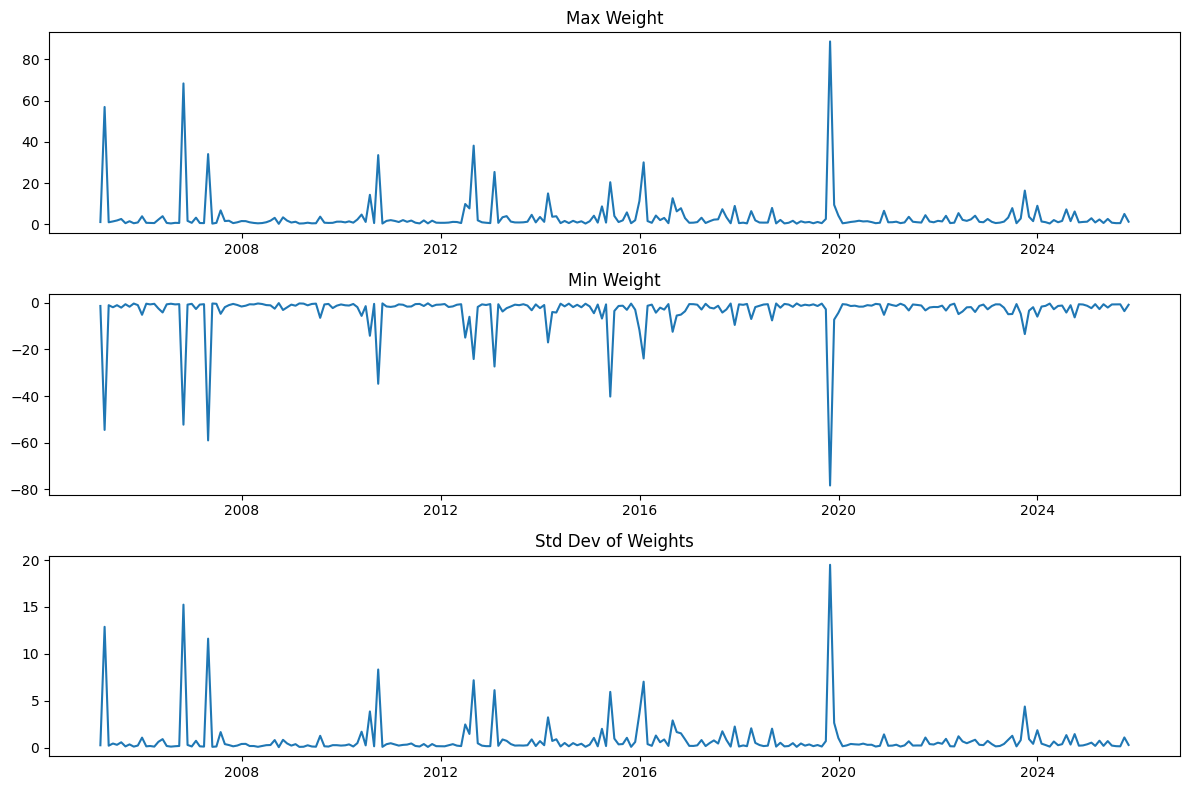

In [ ]:
gmv = GMV_rolling_no_constraints(df_rets).dropna()

max = gmv.max(axis=1)
min = gmv.min(axis=1)
std = gmv.std(axis=1)

figure, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(max)
ax[0].set_title('Max Weight')
ax[1].plot(min)
ax[1].set_title('Min Weight')
ax[2].plot(std)
ax[2].set_title('Std Dev of Weights')
plt.tight_layout()
plt.show()

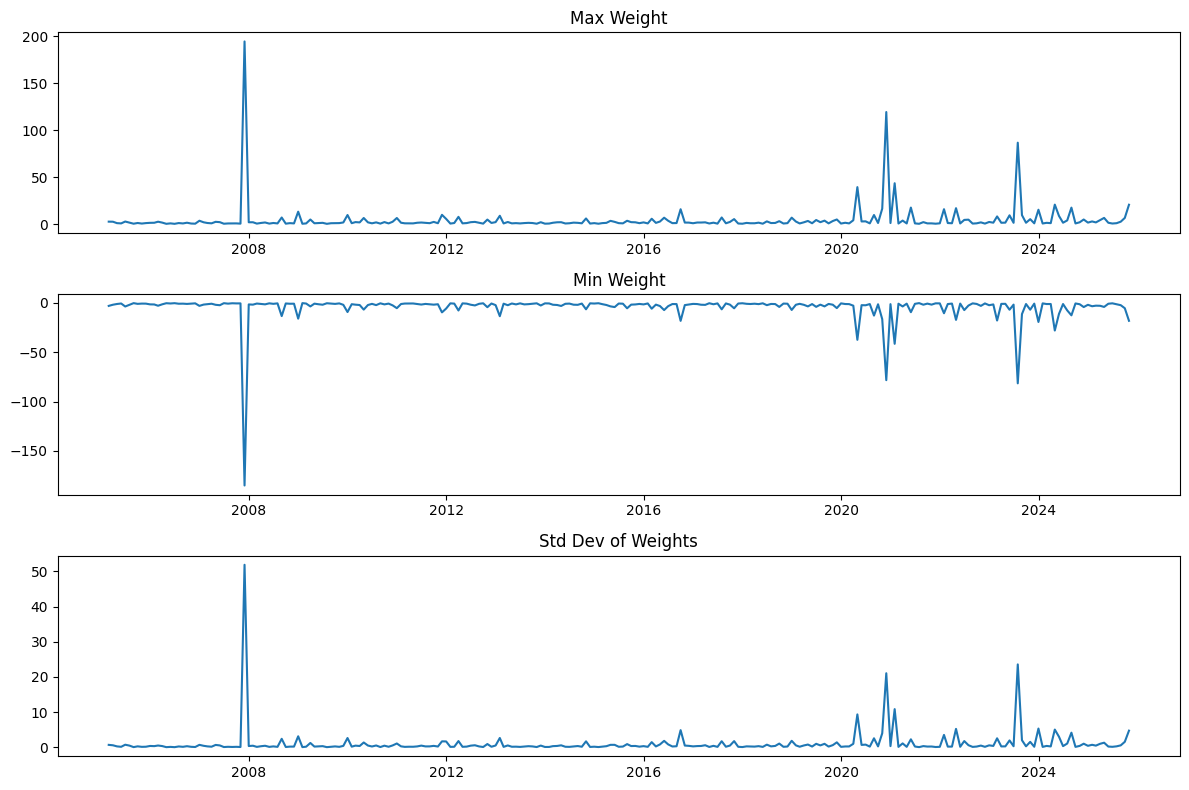

In [14]:
mvp = MVP_rolling_no_constraints(df_rets, rf=0.0).dropna()

max = mvp.max(axis=1)
min = mvp.min(axis=1)
std = mvp.std(axis=1)
figure, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(max)
ax[0].set_title('Max Weight')
ax[1].plot(min)
ax[1].set_title('Min Weight')
ax[2].plot(std)
ax[2].set_title('Std Dev of Weights')
plt.tight_layout()
plt.show()

### Long only weights analysis

100%|██████████| 249/249 [03:35<00:00,  1.15it/s]



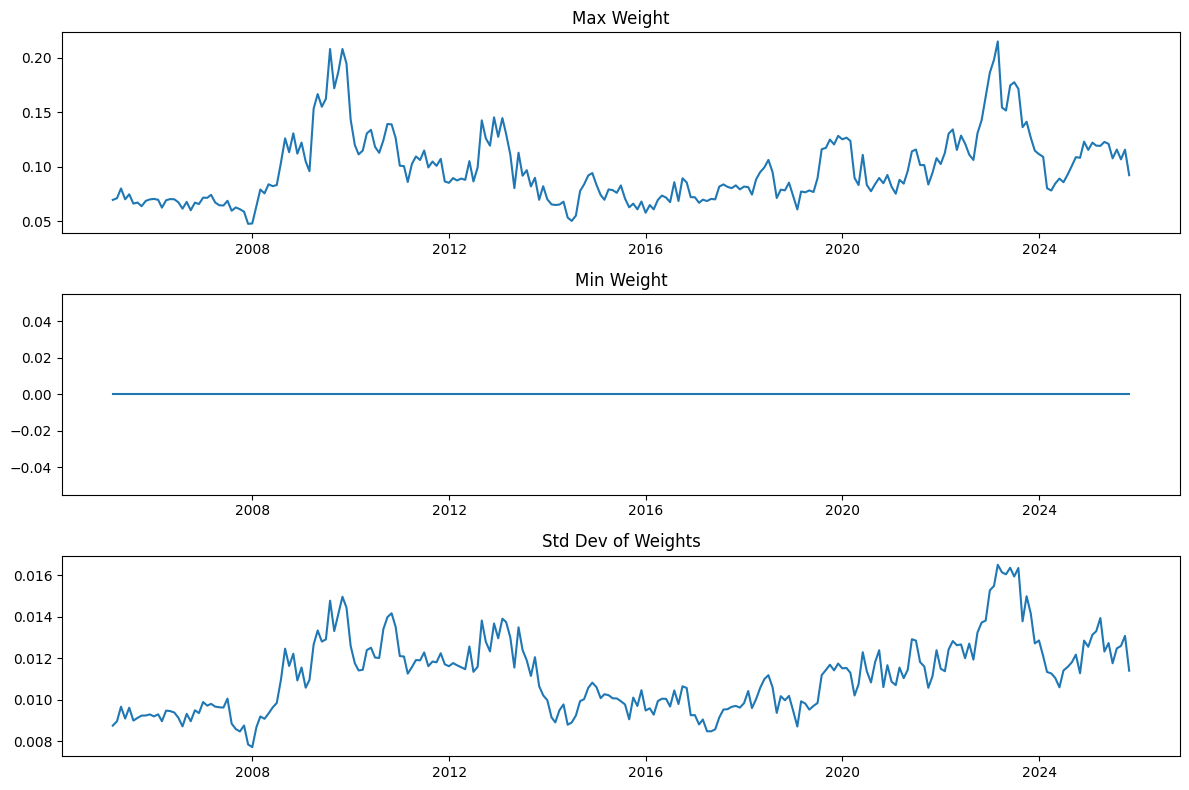

In [29]:
gmv_c = GMV_rolling_window_weights(df_rets, window=60, weights_function=GMV_long_only)

max = gmv_c.max(axis=1)
min = gmv_c.min(axis=1)
std = gmv_c.std(axis=1)

figure, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(max)
ax[0].set_title('Max Weight')
ax[1].plot(min)
ax[1].set_title('Min Weight')
ax[2].plot(std)
ax[2].set_title('Std Dev of Weights')
plt.tight_layout()
plt.show()

100%|██████████| 249/249 [03:33<00:00,  1.16it/s]



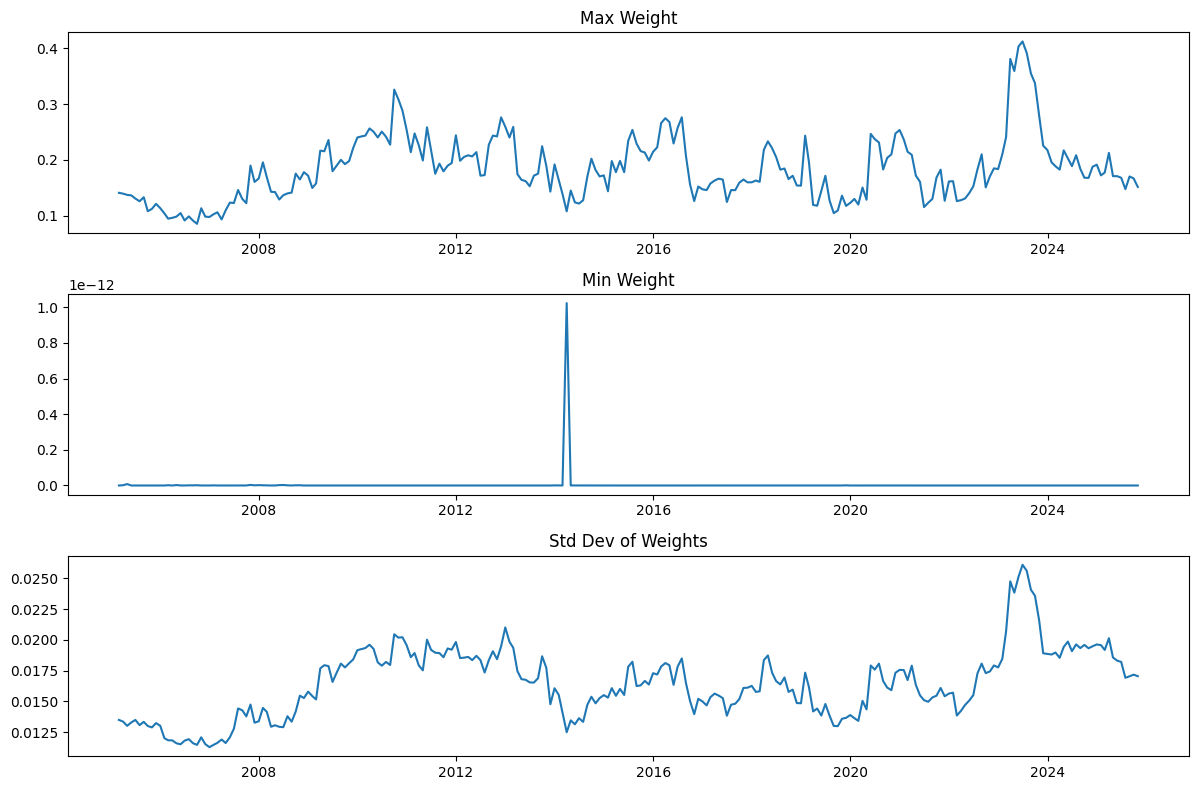

In [27]:
mvp_c = MVP_rolling_window_weights(df_rets, window=60, weights_function=MVP_long_only)

max = mvp_c.max(axis=1)
min = mvp_c.min(axis=1)
std = mvp_c.std(axis=1)

figure, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(max)
ax[0].set_title('Max Weight')
ax[1].plot(min)
ax[1].set_title('Min Weight')
ax[2].plot(std)
ax[2].set_title('Std Dev of Weights')
plt.tight_layout()
plt.show()

### Sharpe Ratio analysis